In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import os
od.download("https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.image as mpimg
import glob

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim


Skipping, found downloaded files in "./pokemon-sprites-images" (use force=True to force download)


In [ ]:
pokemonData = pd.read_csv("pokemon-sprites-images/pokemon_images/pokedex.csv")
print(pokemonData.head())

   id           name  pokedex_id  type1   type2 primary_color      shape  \
0   0      Bulbasaur           1  Grass  Poison         Green  Quadruped   
1   1        Ivysaur           2  Grass  Poison         Green  Quadruped   
2   2       Venusaur           3  Grass  Poison         Green  Quadruped   
3   3  Venusaur Gmax           3  Grass  Poison         Green  Quadruped   
4   4  Venusaur Mega           3  Grass  Poison         Green  Quadruped   

   legendary  mega_evolution  alolan_form  galarian_form  gigantamax image_fn  
0      False           False        False          False       False    ['1']  
1      False           False        False          False       False    ['2']  
2      False           False        False          False       False    ['3']  
3      False           False        False          False        True  ['3_g']  
4      False            True        False          False       False  ['3_2']  


**Przykładowe wyświetlenie**

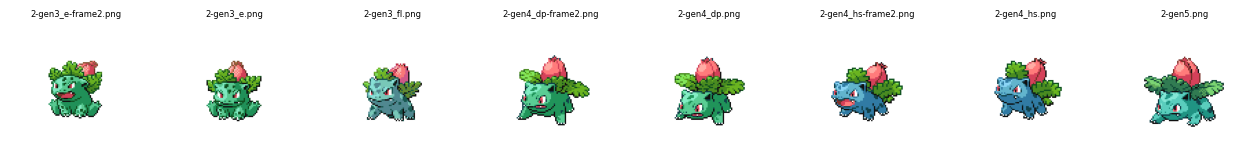

In [ ]:
BASE_DIR = "./pokemon-sprites-images/pokemon_images/sprites"

def show_front_normal_sprites(image_fn_value):

    # ['1'] -> "1"
    pid = str(image_fn_value).strip("[]' ")

    folder = None
    for f in os.listdir(BASE_DIR):
        if f.endswith(f"-{pid}"):
            folder = os.path.join(BASE_DIR, f)
            break

    if folder is None:
        print(f"Nie znaleziono folderu dla Pokemona {pid}")
        return

    # front/normal
    normal_front = os.path.join(folder, "front", "normal")
    if not os.path.exists(normal_front):
        print(f"Brak front/normal dla Pokemona {pid}")
        return

    # Wczytaj wszystkie sprite'y
    files = sorted(os.listdir(normal_front))
    if not files:
        print(f"Brak plików w {normal_front}")
        return

    # Wyświetlenie sprite-ów
    plt.figure(figsize=(len(files)*2, 2))
    for i, fname in enumerate(files):
        sprite_path = os.path.join(normal_front, fname)
        img = mpimg.imread(sprite_path)
        plt.subplot(1, len(files), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname, fontsize=6)
    plt.show()

show_front_normal_sprites("['2']")


**Sprawdzenie braków**

In [ ]:
#pokemonData["name"].isnull().sum()
#pokemonData["type1"].isnull().sum()
#pokemonData["type2"].isnull().sum() #521 braków
#pokemonData["primary_color"].isnull().sum()
#pokemonData["legendary"].isnull().sum()
#pokemonData["mega_evolution"].isnull().sum()
#pokemonData["alolan_form"].isnull().sum()
#pokemonData["galarian_form"].isnull().sum()
#pokemonData["gigantamax"].isnull().sum()
#pokemonData["image_fn"].isnull().sum() # nie ma braków, ale nie wszystkie pokemony mają sprite-y przez co miejsca są oznaczone na "[]"

#pokemonData["image_fn"].value_counts() #brak 46 sprite-ów pokemonów
#pokemonData["type1"].value_counts()
#pokemonData["type2"].value_counts()
#pokemonData["primary_color"].value_counts()
#pokemonData["shape"].value_counts()

Kolumny kategorialne zamieniam na one-hot

**Konwersja danych**

In [ ]:
#Usunięcie "pokemonów" bez sprite-a
pokemonData = pokemonData[pokemonData['image_fn'] != "[]"].reset_index(drop=True)

#Usunięcie zbędnych kolumn id, pokedex_id, images_fn
pokemonData = pokemonData.drop(columns=['pokedex_id', 'image_fn'])

# zmiana id na 4 cyfry żeby połączyć z obrazkami
pokemonData["id"] = pokemonData["id"].astype(str).str.zfill(4)

#Konwersja one-hot dla kolumn: "type1" oraz "type2"
one_hot_types = pd.get_dummies(pokemonData[["type1", "type2"]])
one_hot_types = one_hot_types.groupby(one_hot_types.columns.str.split("_").str[1], axis=1).sum()
one_hot_types = (one_hot_types > 0).astype(int)
pokemonData = pokemonData.drop(columns=['type1', 'type2'])

#Konwersja one-hot dla kolumn: "primary_color" oraz "shape"
one_hot_shapes = pd.get_dummies(pokemonData["shape"], prefix="shape").astype(int)
one_hot_colors = pd.get_dummies(pokemonData["primary_color"], prefix="color").astype(int)
pokemonData = pokemonData.drop(columns=['shape', 'primary_color'])

#Połączenie wszystkiego
pokemonData = pd.concat([pokemonData, one_hot_types, one_hot_shapes, one_hot_colors], axis=1)

#Konwersja kolumn: "legendary", "mega_evolution", "alolan_form", "galarian_form", "gigantamax"; na sposób binarny
pokemonData["legendary"] = pokemonData["legendary"].astype(int)
pokemonData["mega_evolution"] = pokemonData["mega_evolution"].astype(int)
pokemonData["alolan_form"] = pokemonData["alolan_form"].astype(int)
pokemonData["galarian_form"] = pokemonData["galarian_form"].astype(int)
pokemonData["gigantamax"] = pokemonData["gigantamax"].astype(int)


/tmp/ipython-input-2037003887.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  one_hot_types = one_hot_types.groupby(one_hot_types.columns.str.split("_").str[1], axis=1).sum()


In [ ]:
pokemonData.head() #49 kolumn

,id,name,legendary,mega_evolution,alolan_form,galarian_form,gigantamax,Bug,Dark,Dragon,...,color_Black,color_Blue,color_Brown,color_Gray,color_Green,color_Pink,color_Purple,color_Red,color_White,color_Yellow
0,0000,Bulbasaur,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0001,Ivysaur,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0002,Venusaur,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0003,Venusaur Gmax,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0004,Venusaur Mega,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
pokemonData.tail()

,id,name,legendary,mega_evolution,alolan_form,galarian_form,gigantamax,Bug,Dark,Dragon,...,color_Black,color_Blue,color_Brown,color_Gray,color_Green,color_Pink,color_Purple,color_Red,color_White,color_Yellow
1067,1113,Glastrier,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1068,1114,Spectrier,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1069,1115,Calyrex,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1070,1116,Calyrex Ice Rider,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1071,1117,Calyrex Shadow Rider,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
pokemonData.to_csv("pokemon_labels.csv", index=False)